<a href="https://colab.research.google.com/github/daeunni/Statistical_DL/blob/main/lec_code/10_%EB%A8%B8%EC%8B%A0%EB%B2%88%EC%97%AD_Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation
- 영어와 프랑스어 번역하기

In [28]:
import pandas as pd
import numpy as np
import string

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
lines= pd.read_table('/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/english to french.txt', names=['eng', 'fr'])

In [31]:
lines.head(3)

,eng,fr
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !


In [32]:
lines = lines[0:50000]

# 1. Preprocessing 

In [33]:
 # 소문자로 만들기 
lines['eng']=lines['eng'].apply(lambda x: x.lower()) 
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [34]:
# 문장부호 없애기
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))  
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [35]:
lines.head(3)

,eng,fr
0,go,va
1,run,cours
2,run,courez


In [36]:
# start와 end를 추가한다!
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [37]:
lines.head(3)   

,eng,fr
0,go,start va end
1,run,start cours end
2,run,start courez end


In [38]:
lines.shape

(50000, 2)

## 토큰화

In [39]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [40]:
## 영어
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))  

df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)

df['cum_count']=df['count'].cumsum()  # 단어 등장 빈도
df['cum_perc'] = df['cum_count']/df['cum_count'].max()  # 단어 등장 비율
final_eng_words = df[df['cum_perc']<0.8]['word'].values   # 상위 80퍼센트 등장한 단어만 사용

In [41]:
final_eng_words   # 80% 빈도수를 차지하는 총 영어 단어의 수 

array(['i', 'you', 'a', 'is', 'the', 'it', 'to', 'he', 'tom', 'im', 'me',
       'do', 'are', 'this', 'that', 'dont', 'was', 'youre', 'we', 'not',
       'my', 'have', 'your', 'did', 'be', 'were', 'all', 'she', 'its',
       'they', 'like', 'can', 'what', 'go', 'of', 'in', 'very', 'want',
       'no', 'how', 'here', 'him', 'on', 'cant', 'ill', 'thats', 'for',
       'know', 'get', 'up', 'need', 'out', 'at', 'just', 'one', 'his',
       'so', 'now', 'why', 'good', 'there', 'please', 'come', 'with',
       'hes', 'think', 'has', 'too', 'will', 'her', 'love', 'see', 'got',
       'look', 'help', 'am', 'really', 'us', 'had', 'who', 'right',
       'take', 'didnt', 'well', 'let', 'where', 'theyre', 'an', 'feel',
       'must', 'home', 'lets', 'stop', 'made', 'happy', 'back', 'about',
       'ive', 'work', 'time', 'still', 'whats', 'give', 'going', 'may',
       'never', 'them', 'tell', 'car', 'leave', 'alone', 'try', 'busy',
       'could', 'say', 'went', 'saw', 'make', 'much', 'isnt', 'sho

In [42]:
df.head()

,word,count,cum_count,cum_perc
9,i,11307,11307,0.057204
78,you,8787,20094,0.101659
92,a,4899,24993,0.126444
215,is,4468,29461,0.149048
568,the,3808,33269,0.168313


In [43]:
## 프랑스어
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))

df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)

df['cum_count']=df['count'].cumsum()   # 단어 등장 빈도
df['cum_perc'] = df['cum_count']/df['cum_count'].max()  # 단어 등장 비율
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [44]:
final_fr_words    # 80% 빈도수를 차지하는 총 프랑스 단어의 수 

array(['start', 'end', 'je', 'pas', 'de', 'ne', 'vous', 'il', 'le', 'est',
       'nous', 'la', 'à', 'tom', 'que', 'suis', 'un', 'cest', 'jai', 'tu',
       'a', 'en', 'me', 'ce', 'une', 'les', 'ça', 'elle', 'tout', 'êtes',
       'fait', 'sont', 'te', 'qui', 'mon', 'ma', 'faire', 'très',
       'sommes', 'ils', 'des', 'nest', 'veux', 'es', 'estce', 'votre',
       'du', 'se', 'pour', 'elles', 'y', 'bien', 'cela', 'moi', 'peux',
       'comment', 'été', 'pourquoi', 'êtesvous', 'ici', 'besoin', 'ton',
       'personne', 'où', 'avec', 'dans', 'plus', 'tous', 'vraiment',
       'lui', 'lair', 'être', 'aller', 'si', 'cette', 'train', 'au',
       'toi', 'trop', 'faut', 'nai', 'était', 'ai', 'monde', 'avons',
       'son', 'pense', 'maintenant', 'astu', 'dit', 'ont', 'estu',
       'avezvous', 'va', 'bon', 'cétait', 'puisje', 'toutes', 'sur',
       'jaime', 'as', 'là', 'avez', 'ta', 'sest', 'encore', 'temps',
       'sais', 'jamais', 'lai', 'on', 'fais', 'maison', 'quelle',
       'jétais'

In [45]:
df.head()

,word,count,cum_count,cum_perc
0,start,50000,50000,0.158865
2,end,50000,100000,0.31773
20,je,9886,109886,0.34914
66,pas,5758,115644,0.367435
75,de,4663,120307,0.382251


In [46]:
 # 영어, 프랑스어에서 80%차지하는 unique한 단어 개수
print('80% 차지하는 unique한 영어 단어 개수 : ', len(final_eng_words))
print('80% 차지하는 unique한 프랑스 단어 개수 : ', len(final_fr_words)) 

### 80%에 해당하지 않는 단어는 unknown으로 하나의 단어 클래스로 한다. 

80% 차지하는 unique한 영어 단어 개수 :  384
80% 차지하는 unique한 프랑스 단어 개수 :  357


따라서 머신 번역 문제는 385개의 영어 단어를 입력해 358개의 프랑스 단어를 구분하는 문제이다!       
(class가 358개인 다중분류문제, categorical crossentropy)

In [49]:
# 위 80%에 해당하지 않는 단어는 unknown으로 전환한다!
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')  # unknown 
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '   # 공백을 준다
  return x3

# 프랑스어 함수
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '   # 공백을 준다
  return x3

In [48]:
filter_eng_words('he is extremely good')   # extremely > unk 변환! 

'he is unk good '

In [50]:
# unk설정 + 마지막 공백
lines['eng']=lines['eng'].apply(filter_eng_words)
lines['fr']=lines['fr'].apply(filter_fr_words)

In [51]:
lines.head()

,eng,fr
0,go,start va end
1,run,start unk end
2,run,start unk end
3,unk,start ça unk end
4,unk,start au unk end


In [52]:
# 유일한 영어와 프랑스어 집합
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [53]:
# 유일한 영어, 프랑스어 집합
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)

In [61]:
print(input_words[10:20])  # 영어
print(target_words[10:20])  # 프랑스어

print(num_encoder_tokens, num_decoder_tokens)

['am', 'an', 'and', 'angry', 'answer', 'any', 'anybody', 'anyone', 'anything', 'are']
['amis', 'arrête', 'arrêtez', 'as', 'assez', 'astu', 'atil', 'au', 'aucun', 'aucune']
385 358


In [62]:
set(all_french_words) - set(final_fr_words)   # unknown 포함 여부 차이

{'unk'}

In [66]:
print('unknown 포함 유일한 영어 집합 원소 개수 : ', len(input_words))
print('unknown 포함 유일한 프랑스어 집합 원소 개수 : ', len(target_words))

unknown 포함 유일한 영어 집합 원소 개수 :  385
unknown 포함 유일한 프랑스어 집합 원소 개수 :  358


In [68]:
# 인덱스와 단어를 딕셔너리로 매핑
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [69]:
input_token_index

{'a': 1,
 'about': 2,
 'afraid': 3,
 'again': 4,
 'agree': 5,
 'all': 6,
 'almost': 7,
 'alone': 8,
 'already': 9,
 'always': 10,
 'am': 11,
 'an': 12,
 'and': 13,
 'angry': 14,
 'answer': 15,
 'any': 16,
 'anybody': 17,
 'anyone': 18,
 'anything': 19,
 'are': 20,
 'arent': 21,
 'as': 22,
 'ask': 23,
 'asked': 24,
 'at': 25,
 'away': 26,
 'back': 27,
 'bad': 28,
 'be': 29,
 'beautiful': 30,
 'bed': 31,
 'been': 32,
 'being': 33,
 'believe': 34,
 'best': 35,
 'better': 36,
 'bicycle': 37,
 'big': 38,
 'bit': 39,
 'book': 40,
 'books': 41,
 'both': 42,
 'bought': 43,
 'boy': 44,
 'bring': 45,
 'broke': 46,
 'busy': 47,
 'buy': 48,
 'by': 49,
 'call': 50,
 'called': 51,
 'came': 52,
 'can': 53,
 'cant': 54,
 'car': 55,
 'care': 56,
 'careful': 57,
 'cat': 58,
 'caught': 59,
 'close': 60,
 'coffee': 61,
 'cold': 62,
 'come': 63,
 'coming': 64,
 'could': 65,
 'crazy': 66,
 'day': 67,
 'dead': 68,
 'did': 69,
 'didnt': 70,
 'die': 71,
 'died': 72,
 'do': 73,
 'does': 74,
 'doesnt': 75,
 'dog

In [71]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])   # unknown은 336번으로 매핑

336
284
89
unk


In [72]:
# RNN 시간스텝 정의를 위한 가장 긴 문장 찾기

length_list=[]   # 영어
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

length_list=[]   # 프랑스어
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [73]:
print(eng_max_length)   # 영어는 8개의 단어가 가장 긴 문장
print(fr_max_length)    # 프랑스어는 17개의 단어가 가장 긴 문장

8
17


In [74]:
# Time step 기반 RNN Input data 생성(우선 zero로 shape만 맞춰서 생성함)
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')

decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')

decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [77]:
# 시간스텝(단어 수)와 5만개의 문장 수
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)   # 디코더는 358 + 1로 지정(index=0은 그냥 빈 공간으로 정의)
# (표본, 시간스텝, 359개의 단어 원핫 벡터)

(50000, 8)
(50000, 17)
(50000, 17, 359)


- Encoder_input_data : 영어 문장 저장
- Decoder_input_data : 영어 문장에 대응되는 프랑스어 문장
- Decoder_target_data : Decoder_input_data보다 한 시점 앞서게 해서 번역을 예측문제로 전환

> 현재 영어 단어와 프랑스어 단어로 다음에 오는 프랑스어 단어를 예측하는 문제가 된다. 

In [81]:
encoder_input_data[3]

array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [82]:
# 데이터 직접 생성
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):

    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]

    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]

        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1   # 0은 모두 89로 대체함 

In [83]:
print(decoder_input_data.shape, encoder_input_data.shape, decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [85]:
decoder_input_data   # 0은 모두 end를 의미하는 89로 채움! 

array([[284., 321.,  89., ...,  89.,  89.,  89.],
       [284., 320.,  89., ...,  89.,  89.,  89.],
       [284., 320.,  89., ...,  89.,  89.,  89.],
       ...,
       [284., 127., 320., ...,  89.,  89.,  89.],
       [284., 127., 320., ...,  89.,  89.,  89.],
       [284.,  86., 320., ...,  89.,  89.,  89.]], dtype=float32)

In [87]:
encoder_input_data

array([[120.,   0.,   0., ...,   0.,   0.,   0.],
       [264.,   0.,   0., ...,   0.,   0.,   0.],
       [264.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [312., 120., 320., ..., 336.,   0.,   0.],
       [312., 124., 162., ...,   0.,   0.,   0.],
       [312., 124., 162., ...,   0.,   0.,   0.]], dtype=float32)

In [86]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

# 2. Modeling 

### 1. Simple Seq2Seq
- 교사강요를 이용하지 않음

In [88]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout
model1 = Sequential()

# 토큰화 후 임베딩 
model1.add(Embedding(len(input_words)+1, 128, input_length=eng_max_length))     
model1.add(Bidirectional(LSTM(256)))
model1.add(RepeatVector(fr_max_length))  # decoder target size를 맞추기 위해 단순히 17번 복사!
model1.add((LSTM(256, return_sequences=True)))
model1.add((Dense(len(target_token_index)+1, activation='softmax')))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 128)            49408     
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               788480    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 17, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 256)           787456    
_________________________________________________________________
dense (Dense)                (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [89]:
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

In [90]:
history = model1.fit(encoder_input_data, decoder_target_data,   # teacher forcing 이용하지 않음 
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Epoch 1/5
372/372 [==============================] - 25s 15ms/step - loss: 1.5891 - acc: 0.7654 - val_loss: 1.2995 - val_acc: 0.7556
Epoch 2/5
372/372 [==============================] - 5s 12ms/step - loss: 0.9500 - acc: 0.8112 - val_loss: 1.1495 - val_acc: 0.7691
Epoch 3/5
372/372 [==============================] - 5s 12ms/step - loss: 0.8197 - acc: 0.8287 - val_loss: 1.0452 - val_acc: 0.7817
Epoch 4/5
372/372 [==============================] - 5s 12ms/step - loss: 0.7205 - acc: 0.8422 - val_loss: 0.9643 - val_acc: 0.7900
Epoch 5/5
372/372 [==============================] - 5s 13ms/step - loss: 0.6531 - acc: 0.8498 - val_loss: 0.8997 - val_acc: 0.7958


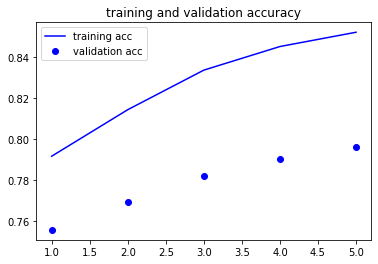

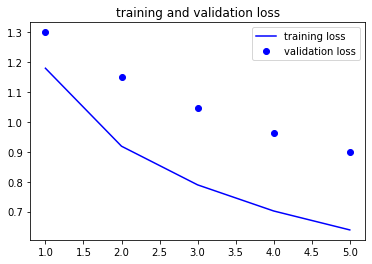

In [91]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [92]:
# 정밀도 구하기 
count = 0
correct_count = 0
pred = model1.predict(encoder_input_data[47500:])
for i in range(2500):
    t = np.argmax(pred[i], axis=-1)
    act=np.argmax(decoder_target_data[47500+i], axis=-1)
    correct_count += np.sum((act==t) & (act!=89))
    count += np.sum(act!=89)  # 정밀도 구할 때는 89 (end) 의미하는 단어는 빼고 하기 
print(correct_count, count)
print(correct_count/count)

5159 13426
0.38425443169968715


In [93]:
encoder_input_data[-2400]  

array([155.,  98., 185., 336.,   0.,   0.,   0.,   0.], dtype=float32)

In [94]:
# 예측 현황 
t = model1.predict(encoder_input_data[-2400].reshape(1,encoder_input_data.shape[1])).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

je
me
unk
unk
unk
end
end
end
end
end
end
end
end
end
end
end
end


## 2. Teaching force Encoder-Decoder

In [96]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout

# functional API로 구성 
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)   # 임베딩 층 
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
encoder_states = [state_h, state_c]

In [97]:
decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1, 128)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dex,initial_state=encoder_states)
decoder_outputs = Dense(2000,activation='tanh')(decoder_outputs)
decoder_dense = Dense(num_decoder_tokens+1, activation='softmax')(decoder_outputs)

model2 = Model([encoder_inputs, decoder_inputs], decoder_dense)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [98]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 8, 128)       49408       input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 17, 128)      45952       input_3[0][0]                    
______________________________________________________________________________________________

In [99]:
history2 = model2.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Epoch 1/5
372/372 [==============================] - 7s 13ms/step - loss: 1.4293 - acc: 0.7784 - val_loss: 1.0620 - val_acc: 0.7864
Epoch 2/5
372/372 [==============================] - 4s 11ms/step - loss: 0.7091 - acc: 0.8510 - val_loss: 0.8153 - val_acc: 0.8154
Epoch 3/5
372/372 [==============================] - 4s 11ms/step - loss: 0.5386 - acc: 0.8736 - val_loss: 0.7077 - val_acc: 0.8308
Epoch 4/5
372/372 [==============================] - 4s 11ms/step - loss: 0.4543 - acc: 0.8866 - val_loss: 0.6267 - val_acc: 0.8426
Epoch 5/5
372/372 [==============================] - 4s 11ms/step - loss: 0.3962 - acc: 0.8973 - val_loss: 0.5925 - val_acc: 0.8494


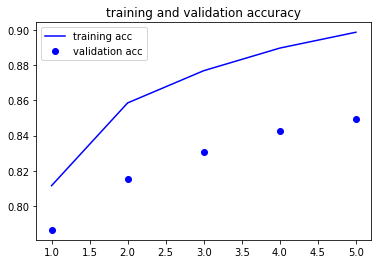

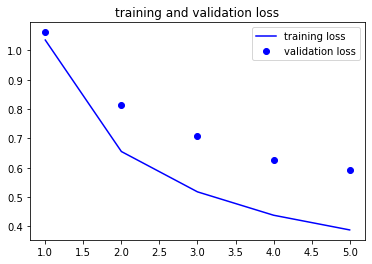

In [100]:
import matplotlib.pyplot as plt
acc=history2.history['acc']
val_acc=history2.history['val_acc']
loss=history2.history['loss']
val_loss=history2.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [102]:
# count = 0
# correct_count = 0
# pred = model2.predict([encoder_input_data[47500:],decoder_input_data[47500:]])
# for i in range(2500):
#   t = np.argmax(pred[i], axis=-1)
#   correct_count += np.sum((act[47500+i]==t) & (act[47500+i]!=89))
#   count += np.sum(decoder_input_data[47500+i]!=89)
# print(correct_count,count)
# print(correct_count/count)